In [68]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import uncertainties.unumpy as unp
from uncertainties import ufloat
import scipy.constants as const
from uncertainties.unumpy import nominal_values as noms
from uncertainties.unumpy import std_devs as stds
import pandas as pd

In [69]:
# reading data
df_sim = pd.DataFrame()

names = ["y_exit", "z_exit", "x_start", "y_start", "z_start", "px_start", "py_start", "pz_start", "reflCoCl", "reflClCl", "wl", "gpsPosX", "length_core", "length_clad", "rayleighScatterings"]

for i in range(50):
    frame = pd.read_csv(f"content/data/Simulation/job_{i}.txt", sep="\s+", comment = "#", names = names)
    df_sim = df_sim.append(frame)

print(df_sim.head())


     y_exit    z_exit      x_start   y_start   z_start  px_start  py_start  \
0 -0.026978 -0.061619  2400.019897 -0.051878  0.096635  0.948434  0.162628   
1 -0.055254  0.050902  2400.000732  0.085666  0.015889  0.977825 -0.139056   
2  0.049212  0.065583  2399.990967  0.006511 -0.025208  0.917937 -0.225034   
3 -0.018177 -0.106197  2400.062012 -0.043234 -0.098842  0.885576  0.074564   
4  0.050591  0.043467  2400.000977 -0.004035 -0.069628  0.971248 -0.103995   

   pz_start  reflCoCl  reflClCl          wl  gpsPosX  length_core  \
0 -0.272077    3649.0       0.0  472.743103   2400.0  2530.557861   
1 -0.156593    2674.0       0.0  504.521210   2400.0  2454.456055   
2  0.326729       0.0    3894.0  442.621185   2400.0  2204.132568   
3 -0.458470       0.0    5517.0  484.213989   2400.0  2210.260498   
4 -0.214154    2757.0       0.0  489.916565   2400.0  2470.986084   

   length_clad  rayleighScatterings  
0     0.000000                  0.0  
1     0.000000                  0.0  
2 

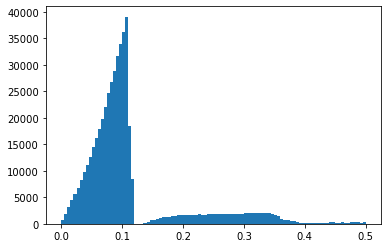

In [70]:
df_sim["r_exit"] = np.sqrt(df_sim["y_exit"]**2 + df_sim["z_exit"]**2)

_, bins, _ = plt.hist(df_sim["r_exit"], bins = 100, range = [0, 0.5])

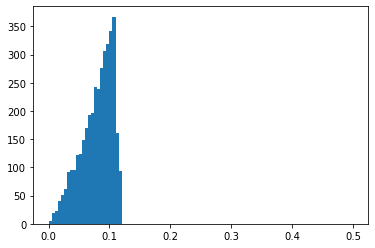

In [71]:
df_sim = df_sim.drop(df_sim[df_sim.r_exit > 0.125].index)
plt.hist(df_sim["r_exit"], bins = bins);

In [72]:
print(df_sim.size)
df_sim = df_sim.drop(df_sim[df_sim["rayleighScatterings"] > 0].index)
print(df_sim.size)

60480
50928


In [73]:
df_sim["inCladding"] = df_sim["r_exit"] > 0.11
df_sim["Theta"] = np.arccos(df_sim["px_start"])/np.pi*180

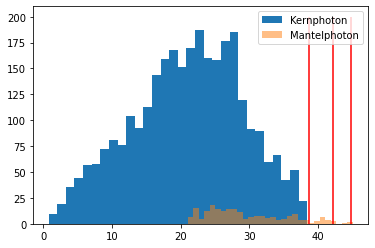

In [81]:
_, bins, _ = plt.hist(df_sim["Theta"][df_sim["inCladding"] == False], bins = 30, label = "Kernphoton")
_, bins, _ = plt.hist(df_sim["Theta"][df_sim["inCladding"] == True], bins = 30, alpha = 0.5, label = "Mantelphoton")
plt.vlines([38.68, 42.16, 44.77], 0, 200, color = "red");
plt.legend()

In [75]:
df_sim.groupby(["inCladding"])["Theta"].max()

inCladding
False    38.401762
True     45.065029
Name: Theta, dtype: float64

In [76]:
# Abstand zum Mittelpunkt (Abstand Gerade-Gerade)

def distance_lineline(v1, v2, p1, p2): # v1, v2, p1, p2 should be numpy arrays
    cross_prod = np.cross(v1, v2)
    if np.all(cross_prod == 0):
        return np.linalg.norm(p1 - p2)
    n = cross_prod / np.linalg.norm(cross_prod)
    return np.abs(np.dot(n, (p1 - p2)))

def r_min(px, py, pz, x, y, z):
    a = np.array([x, y, z])
    p = np.array([px, py, pz])
    return distance_lineline(np.array([1, 0, 0]), p, np.zeros(3), a)


In [77]:
df_sim['r_min'] = df_sim.apply(lambda row: r_min(row['px_start'], row['py_start'], row['pz_start'],
                                                 row['x_start'], row['y_start'], row['z_start']), axis=1)

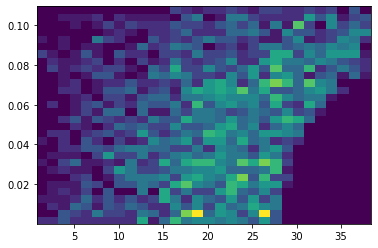

In [85]:
plt.hist2d(df_sim["Theta"][df_sim["inCladding"] == False], 
           df_sim["r_min"][df_sim["inCladding"] == False],
           bins = 30, label = "Kernphoton");

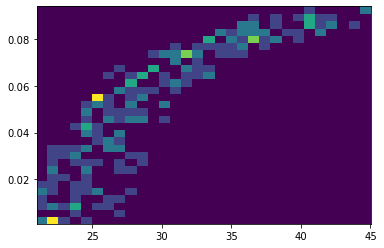

In [79]:
plt.hist2d(df_sim["Theta"][df_sim["inCladding"] == True], 
           df_sim["r_min"][df_sim["inCladding"] == True],
           bins = 30, label = "Kernphoton");

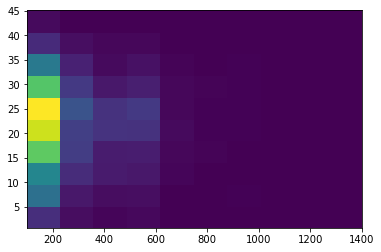

In [83]:
plt.hist2d(df_sim["gpsPosX"], df_sim["Theta"], label = "Kernphoton");